### Load packages

In [2]:
%matplotlib inline

import datacube
from datacube.storage import masking
import matplotlib.pyplot as plt
import numpy as np
import sys
import xarray as xr

sys.path.append("../Scripts")
from dea_plotting import display_map
from dea_datahandling import wofs_fuser

### Connect to the datacube

In [3]:
dc = datacube.Datacube(app="Applying_WOfS_bitmasking")

### Analysis parameters

In [4]:
# Define your period of interest
time = ("2010-01-01", "2010-12-31")

res_x = 100
res_y = -100

In [5]:
location = 'Kakadu'
min_x = 0
max_x = 100000
min_y = -1350000
max_y = -1250000

location = 'Murray Valley'
min_x = 1100000
max_x = 1200000
min_y = -4000000
max_y = -3900000

### View the selected location

In [6]:
# Make sure to change the location for in the save file
location = 'Kakadu'
min_x = 0
max_x = 100000
min_y = -1350000
max_y = -1250000

x = (min_x, max_x)
y = (min_y, max_y)

# Display an interactive map
display_map(x=x, y=y, crs='EPSG:3577', margin=-0.1) 

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Load WOFL data


To load WOFL data, we can first create a re-usable query that will define the spatial extent and time period we are interested in, as well as other important parameters that are used to correctly load the data.

As WOFLs are created scene-by-scene, and some scenes overlap, it's important when loading data to `group_by` solar day, and ensure that the data between scenes is combined correctly by using the WOfS `fuse_func`.
This will merge observations taken on the same day, and ensure that important data isn't lost when overlapping datasets are combined.

In [7]:
# Create a reusable query
query = {
    "x": x,
    "y": y,
    "time": time,
    "crs": "EPSG:3577",
    "output_crs": "EPSG:3577",
    "resolution": (-25, 25),
    "group_by": "solar_day",
    "fuse_func": wofs_fuser,
}

In [8]:
# Load the data from the datacube
wofls = dc.load(product="wofs_albers", **query)
wofls

<xarray.Dataset>
Dimensions:  (time: 61, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    water    (time, y, x) int16 132 132 132 132 132 132 132 ... 2 2 2 2 2 2 2
Attributes:
    crs:      EPSG:3577

### Understanding the WOFLs

As mentioned above, WOFLs are stored as a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular feature. Below is a breakdown of which bits represent which features, along with the decimal value associated with that bit being set to true.

| Attribute | Bit / position   | Decimal value |
|------|------|----|
| No data | 0:   `0-------` or `1-------` | 1|
| Non contiguous | 1:   `-0------` or `-1------` | 2 |
| Sea | 2:   `--0-----` or `--1-----` | 4 |
| Terrain or low solar angle | 3:   `---0----` or `---1----` | 8 |
| High slope | 4:   `----0---` or `----1---` | 16 |
| Cloud shadow | 5:   `-----0--` or `-----1--` | 32 |
| Cloud | 6:   `------0-` or `------1-` | 64 |
| Water | 7:   `-------0` or `-------1` | 128 |


The values in the above plots are the decimal representation of the combination of set flags. 
For example a value of 136 indicates water (128) AND terrain shadow / low solar angle (8) were observed for the pixel,
whereas a value of 144 would indicate water (128) AND high slope (16).

This flag information is available inside the loaded data and can be visualised as below

In [12]:
# Display details of available flags
flags = masking.describe_variable_flags(wofls)
flags["bits"] = flags["bits"].astype(str)
flags.sort_values(by="bits")

,bits,values,description
nodata,0,"{'0': False, '1': True}",No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing over over/unde...
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",terrain shadow or low solar angle
high_slope,4,"{'0': False, '1': True}",High slope
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
cloud,6,"{'0': False, '1': True}",Cloudy
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},No water detected
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


## Load in Fractional Cover

In [15]:
# Load a fractional cover (FC) tile to match the WOFLs data by using 'like'
fc = dc.load(product=["ls5_fc_albers","ls7_fc_albers"], group_by="solar_day", like=wofls)
fc

<xarray.Dataset>
Dimensions:  (time: 61, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    BS       (time, y, x) int16 0 2 0 0 0 2 0 5 0 ... -1 -1 -1 -1 -1 -1 -1 -1 -1
    PV       (time, y, x) int16 51 53 51 48 58 43 49 61 ... -1 -1 -1 -1 -1 -1 -1
    NPV      (time, y, x) int16 56 50 55 58 48 60 57 40 ... -1 -1 -1 -1 -1 -1 -1
    UE       (time, y, x) int16 24 24 24 24 24 23 24 25 ... -1 -1 -1 -1 -1 -1 -1
Attributes:
    crs:      EPSG:3577

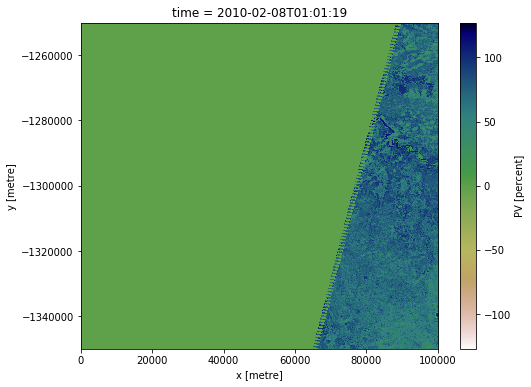

In [16]:
# Visualise an example tile
fc1 = fc.isel(time=7)
fc1.PV.plot.imshow(cmap="gist_earth_r", figsize=(8, 6))
plt.show()

## Gabrielle's struggle town

In [20]:
# Check before merge
fc

<xarray.Dataset>
Dimensions:  (time: 61, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    BS       (time, y, x) int16 0 2 0 0 0 2 0 5 0 ... -1 -1 -1 -1 -1 -1 -1 -1 -1
    PV       (time, y, x) int16 51 53 51 48 58 43 49 61 ... -1 -1 -1 -1 -1 -1 -1
    NPV      (time, y, x) int16 56 50 55 58 48 60 57 40 ... -1 -1 -1 -1 -1 -1 -1
    UE       (time, y, x) int16 24 24 24 24 24 23 24 25 ... -1 -1 -1 -1 -1 -1 -1
Attributes:
    crs:      EPSG:3577

In [21]:
# Check before merge
wofls

<xarray.Dataset>
Dimensions:  (time: 61, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    water    (time, y, x) int16 132 132 132 132 132 132 132 ... 2 2 2 2 2 2 2
Attributes:
    crs:      EPSG:3577

In [22]:
# Merge the two datasets
merged = xr.merge([fc,wofls])
merged

<xarray.Dataset>
Dimensions:  (time: 61, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    BS       (time, y, x) int16 0 2 0 0 0 2 0 5 0 ... -1 -1 -1 -1 -1 -1 -1 -1 -1
    PV       (time, y, x) int16 51 53 51 48 58 43 49 61 ... -1 -1 -1 -1 -1 -1 -1
    NPV      (time, y, x) int16 56 50 55 58 48 60 57 40 ... -1 -1 -1 -1 -1 -1 -1
    UE       (time, y, x) int16 24 24 24 24 24 23 24 25 ... -1 -1 -1 -1 -1 -1 -1
    water    (time, y, x) int16 132 132 132 132 132 132 132 ... 2 2 2 2 2 2 2

In [36]:
# Select an individual time
test = merged.isel(time=13)

# Mask out where unclear pixels
test_masked = test.where(test.water == 1,test)
test_masked

<xarray.Dataset>
Dimensions:   (x: 4000, y: 4000)
Coordinates:
    time      datetime64[ns] 2010-03-19T01:07:34
  * y         (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x         (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    BS        (y, x) int16 5 30 0 0 8 23 0 0 0 4 ... -1 -1 -1 -1 -1 -1 -1 -1 -1
    PV        (y, x) int16 37 39 29 29 31 34 33 34 ... -1 -1 -1 -1 -1 -1 -1 -1
    NPV       (y, x) int16 62 36 76 76 65 47 72 71 ... -1 -1 -1 -1 -1 -1 -1 -1
    UE        (y, x) int16 21 21 21 21 21 20 20 21 ... -1 -1 -1 -1 -1 -1 -1 -1
    water     (y, x) int16 196 196 196 196 196 196 ... 131 131 131 131 131 131
    PV_filt   (y, x) float32 37.0 39.0 29.0 29.0 31.0 ... nan nan nan nan nan
    NPV_filt  (y, x) float32 37.0 39.0 29.0 29.0 31.0 ... nan nan nan nan nan
    BS_filt   (y, x) float32 37.0 39.0 29.0 29.0 31.0 ... nan nan nan nan nan

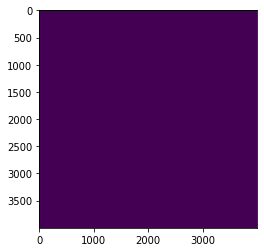

In [45]:
# Visualise the mask
plt.imshow(test.water.data==4) # 4 should be the ocean and yet it does not show up

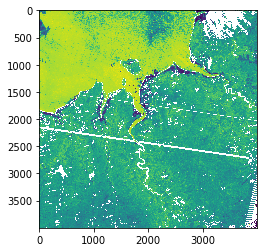

In [38]:
# Visualise the tile after masking
masked = test.PV.data.astype(np.float32)
masked[test.water.data == 1] = np.nan # no data
masked[test.water.data == 2] = np.nan # non-contiguous
masked[test.water.data == 4] = np.nan # sea
masked[test.water.data == 8] = np.nan # terrain or low slope
masked[test.water.data == 16] = np.nan # high slope
masked[test.water.data == 32] = np.nan # cloud shadow
masked[test.water.data == 64] = np.nan # cloud
masked[test.water.data == 128] = np.nan # cloud
plt.imshow(masked)

## Apply masking to merged dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


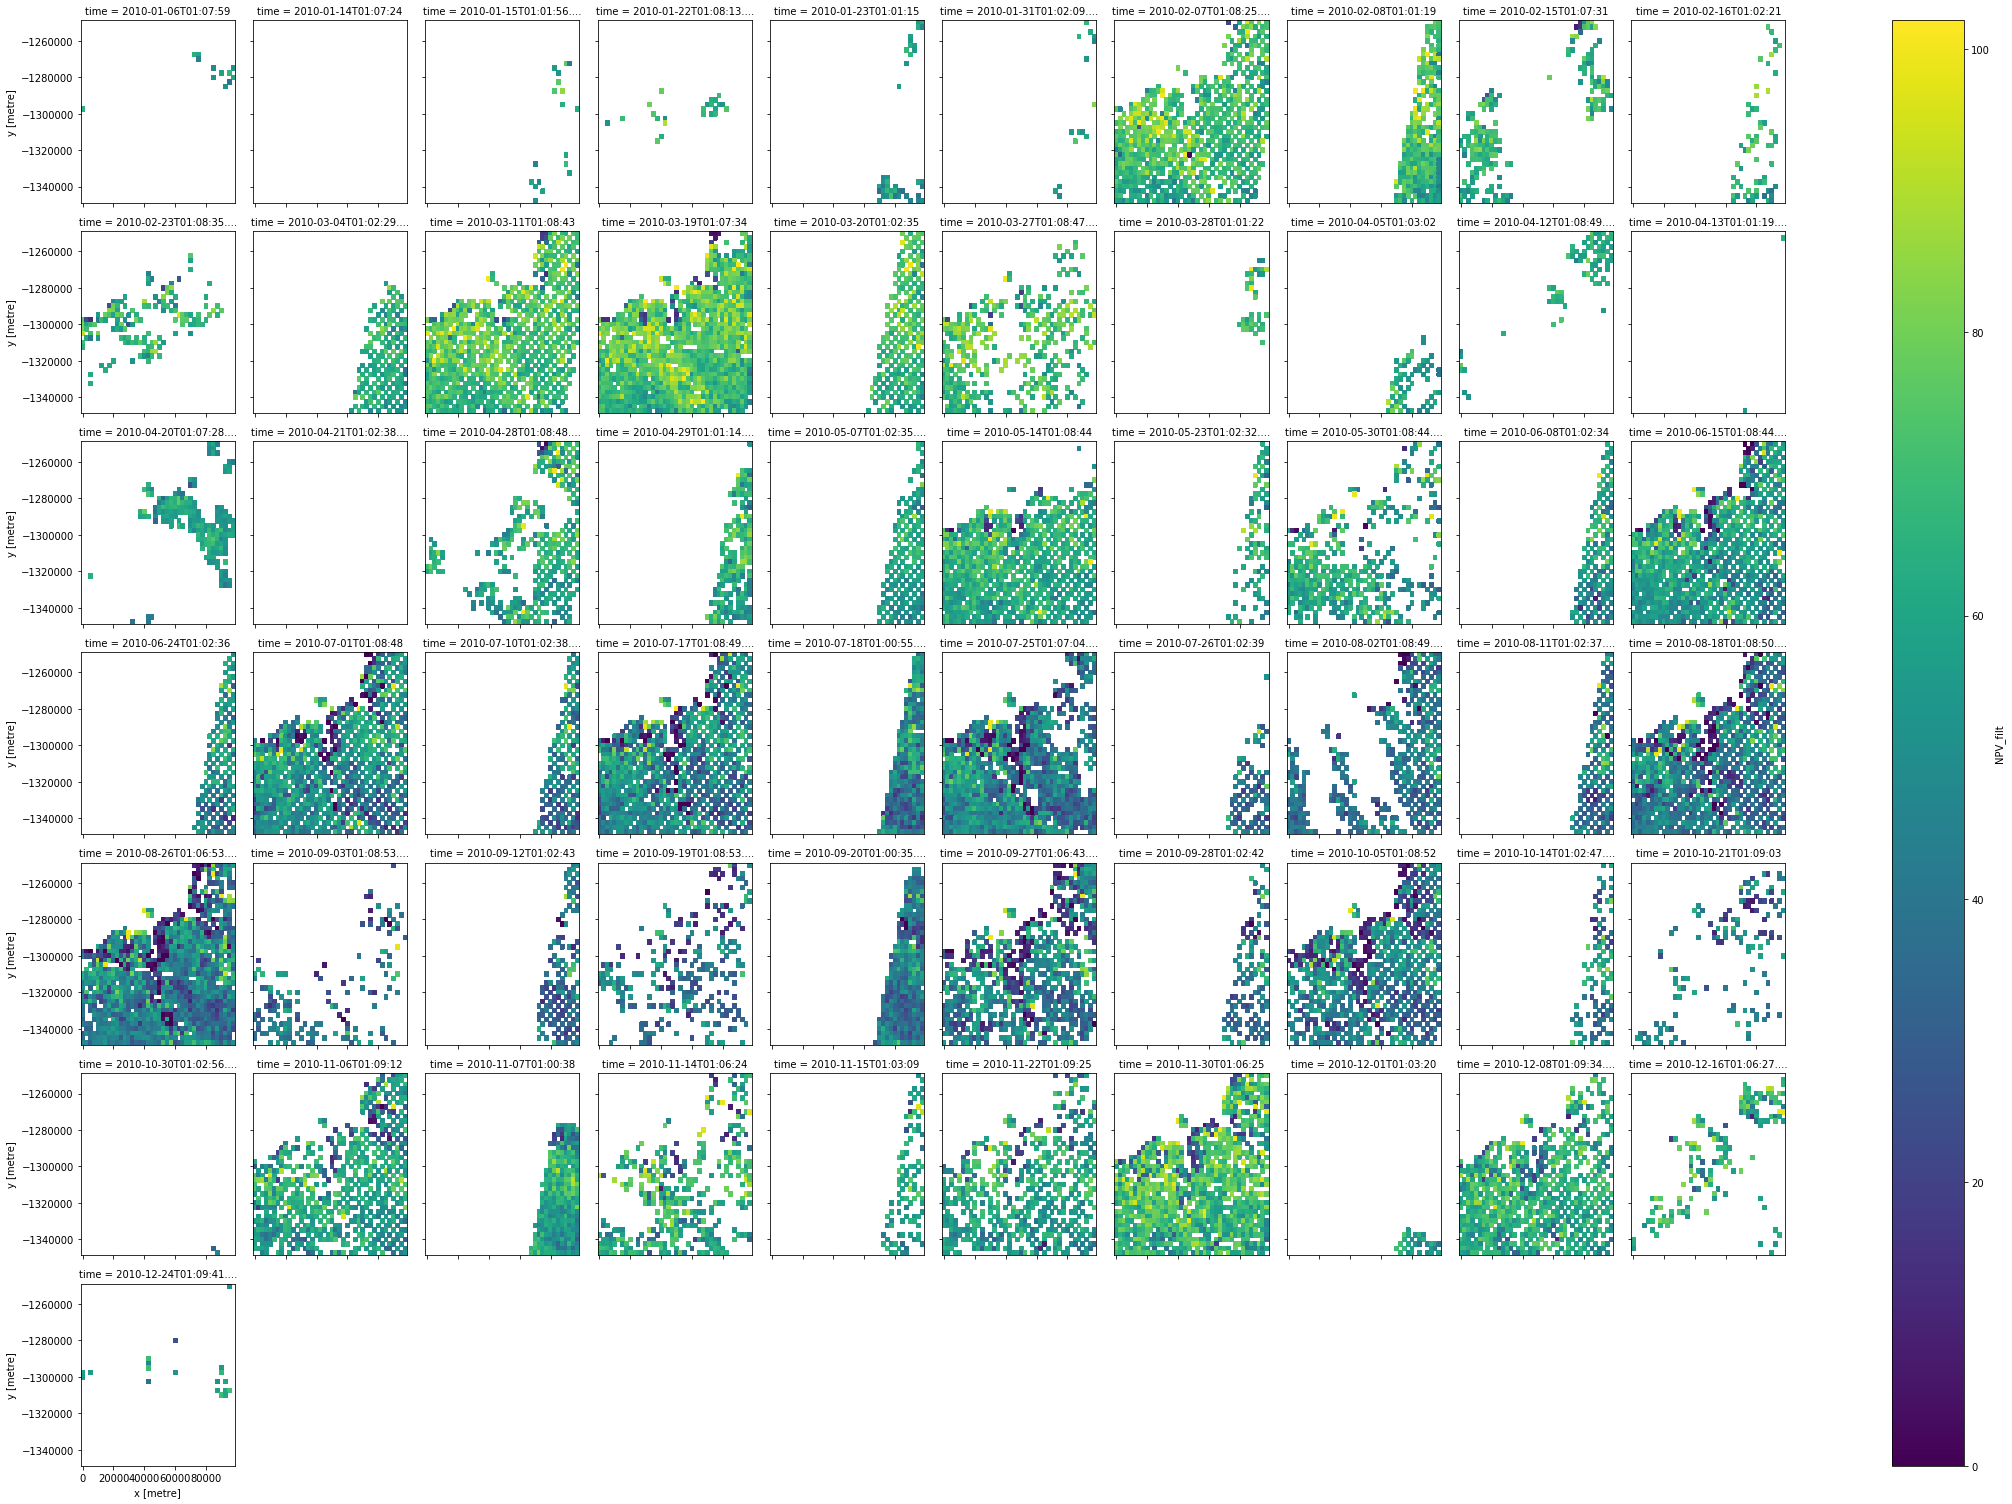

In [41]:
# Make a merged dataset of fc and wofls
merged = xr.merge([fc,wofls],join='inner')

# Create a new band/data variable
merged['PV_filt'] = merged.PV.astype(np.float32)
merged['NPV_filt'] = merged.PV.astype(np.float32)
merged['BS_filt'] = merged.PV.astype(np.float32)

# Set new band to be nan based on water band
merged.PV_filt.data[merged.water.data != 0] = np.nan # no data (1,2,4,8,16,32,64,128)
merged.NPV_filt.data[merged.water.data != 0] = np.nan # no data
merged.BS_filt.data[merged.water.data != 0] = np.nan # no data

# Set FC < 0 (no data) to nan
merged.PV_filt.data[merged.PV_filt.data <0] = np.nan # no data
merged.NPV_filt.data[merged.NPV_filt.data <0] = np.nan # no data
merged.BS_filt.data[merged.BS_filt.data <0] = np.nan # no data

# merged.PV_filt.data[merged.wNPV_filtater.data == 2] = np.nan # non-contiguous
# merged.PV_filt.data[merged.water.data == 4] = np.nan # sea
# merged.PV_filt.data[merged.water.data == 8] = np.nan # terrain or low slope
# merged.PV_filt.data[merged.water.data == 16] = np.nan # high slope
# merged.PV_filt.data[merged.water.data == 32] = np.nan # cloud shadow
# merged.PV_filt.data[merged.water.data == 64] = np.nan # cloud
# merged.PV_filt.data[merged.water.data == 128] = np.nan # cloud

merged.NPV_filt[:,::100,::100].plot(col='time',col_wrap=10)

In [42]:
# See than new bands masked are avaliable
merged

<xarray.Dataset>
Dimensions:   (time: 61, x: 4000, y: 4000)
Coordinates:
  * time      (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y         (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x         (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    BS        (time, y, x) int16 0 2 0 0 0 2 0 5 0 ... -1 -1 -1 -1 -1 -1 -1 -1
    PV        (time, y, x) int16 51 53 51 48 58 43 49 ... -1 -1 -1 -1 -1 -1 -1
    NPV       (time, y, x) int16 56 50 55 58 48 60 57 ... -1 -1 -1 -1 -1 -1 -1
    UE        (time, y, x) int16 24 24 24 24 24 23 24 ... -1 -1 -1 -1 -1 -1 -1
    water     (time, y, x) int16 132 132 132 132 132 132 132 ... 2 2 2 2 2 2 2
    PV_filt   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    NPV_filt  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    BS_filt   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [43]:
# Calculate the annual median
median = merged.median(dim='time')
median

<xarray.Dataset>
Dimensions:   (x: 4000, y: 4000)
Coordinates:
  * y         (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x         (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    BS        (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... -1.0 -1.0 -1.0 -1.0 -1.0
    PV        (y, x) float64 15.0 16.0 17.0 15.0 17.0 ... -1.0 -1.0 -1.0 -1.0
    NPV       (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... -1.0 -1.0 -1.0 -1.0 -1.0
    UE        (y, x) float64 4.0 5.0 5.0 5.0 5.0 ... -1.0 -1.0 -1.0 -1.0 -1.0
    water     (y, x) float64 196.0 196.0 196.0 196.0 ... 64.0 64.0 64.0 64.0
    PV_filt   (y, x) float32 nan nan nan nan nan ... 40.0 36.5 35.5 37.5 43.0
    NPV_filt  (y, x) float32 nan nan nan nan nan ... 40.0 36.5 35.5 37.5 43.0
    BS_filt   (y, x) float32 nan nan nan nan nan ... 40.0 36.5 35.5 37.5 43.0

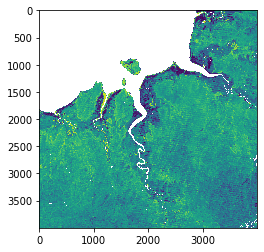

In [44]:
# Visualise the mask
plt.imshow(median.PV_filt)

## Garbage

### Attempt to apply function

In [30]:
# Define function to mask images
def wofs_mask(image):
    masked = image.PV.data.astype(np.float32)
    masked[test.water.data == 1] = np.nan # no data
    masked[test.water.data == 2] = np.nan # non-contiguous
    masked[test.water.data == 4] = np.nan # sea
    masked[test.water.data == 8] = np.nan # terrain or low slope
    masked[test.water.data == 16] = np.nan # high slope
    masked[test.water.data == 32] = np.nan # cloud shadow
    masked[test.water.data == 64] = np.nan # cloud
    masked[test.water.data == 128] = np.nan # cloud
    return masked

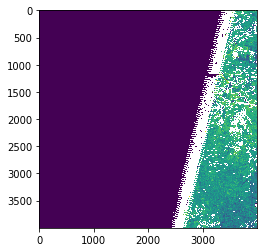

In [31]:
# Apply mask to test
plt.imshow(wofs_mask(test))

In [32]:
times = list(range(0,61))
ds = xr.Dataset()

for i in times:
    masked = wofs_mask(merged.isel(time=i))
    xarray = xr.DataArray(masked,dims=('x', 'y')).expand_dims('time')
    ds['masked'+str(i)] = xarray

In [33]:
ds

<xarray.Dataset>
Dimensions:   (time: 1, x: 4000, y: 4000)
Dimensions without coordinates: time, x, y
Data variables:
    masked0   (time, x, y) float32 51.0 53.0 51.0 48.0 ... -1.0 -1.0 -1.0 -1.0
    masked1   (time, x, y) float32 16.0 16.0 15.0 15.0 ... -1.0 -1.0 -1.0 -1.0
    masked2   (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked3   (time, x, y) float32 61.0 68.0 67.0 64.0 ... -1.0 -1.0 -1.0 -1.0
    masked4   (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 33.0 31.0 36.0 40.0
    masked5   (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked6   (time, x, y) float32 39.0 45.0 52.0 52.0 ... -1.0 -1.0 -1.0 -1.0
    masked7   (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 39.0 38.0 43.0 48.0
    masked8   (time, x, y) float32 60.0 57.0 52.0 53.0 ... -1.0 -1.0 -1.0 -1.0
    masked9   (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 35.0 36.0 40.0 45.0
    masked10  (time, x, y) float32 56.0 55.0 56.0 56.0 ... -1.0 -1.0 -1.0 -1.0
    masked11  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked12  (time, x, y) float32 108.0 108.0 109.0 111.0 ... -1.0 -1.0 -1.0
    masked13  (time, x, y) float32 37.0 39.0 29.0 29.0 ... -1.0 -1.0 -1.0 -1.0
    masked14  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 39.0 39.0 44.0 50.0
    masked15  (time, x, y) float32 112.0 112.0 111.0 110.0 ... -1.0 -1.0 -1.0
    masked16  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 33.0 32.0 31.0 34.0
    masked17  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 42.0 37.0 37.0 39.0
    masked18  (time, x, y) float32 107.0 112.0 111.0 96.0 ... -1.0 -1.0 -1.0
    masked19  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 43.0 43.0 42.0 41.0
    masked20  (time, x, y) float32 101.0 100.0 90.0 96.0 ... -1.0 -1.0 -1.0 -1.0
    masked21  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked22  (time, x, y) float32 101.0 101.0 101.0 101.0 ... -1.0 -1.0 -1.0
    masked23  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 44.0 40.0 43.0 49.0
    masked24  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 35.0 35.0 36.0 40.0
    masked25  (time, x, y) float32 15.0 13.0 17.0 15.0 ... -1.0 -1.0 -1.0 -1.0
    masked26  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked27  (time, x, y) float32 55.0 49.0 58.0 55.0 ... -1.0 -1.0 -1.0 -1.0
    masked28  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked29  (time, x, y) float32 120.0 127.0 116.0 124.0 ... -1.0 -1.0 -1.0
    masked30  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 37.0 35.0 37.0 42.0
    masked31  (time, x, y) float32 123.0 119.0 120.0 119.0 ... -1.0 -1.0 -1.0
    masked32  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked33  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked34  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 36.0 31.0 37.0 42.0
    masked35  (time, x, y) float32 120.0 117.0 115.0 115.0 ... -1.0 -1.0 -1.0
    masked36  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 34.0 33.0 36.0 40.0
    masked37  (time, x, y) float32 32.0 30.0 36.0 33.0 ... -1.0 -1.0 -1.0 -1.0
    masked38  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 33.0 33.0 37.0 41.0
    masked39  (time, x, y) float32 119.0 117.0 119.0 119.0 ... -1.0 -1.0 -1.0
    masked40  (time, x, y) float32 119.0 119.0 116.0 117.0 ... -1.0 -1.0 -1.0
    masked41  (time, x, y) float32 24.0 26.0 27.0 32.0 ... -1.0 -1.0 -1.0 -1.0
    masked42  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 25.0 26.0 28.0 32.0
    masked43  (time, x, y) float32 113.0 114.0 114.0 113.0 ... -1.0 -1.0 -1.0
    masked44  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 37.0 36.0 38.0 44.0
    masked45  (time, x, y) float32 113.0 113.0 114.0 113.0 ... -1.0 -1.0 -1.0
    masked46  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked47  (time, x, y) float32 -1.0 99.0 98.0 89.0 ... -1.0 -1.0 -1.0 -1.0
    masked48  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 19.0 20.0 22.0 26.0
    masked49  (time, 

### Other

In [34]:
masked = wofs_mask(merged.isel(time=7))
xarray = xr.DataArray(masked,dims=('x', 'y')).expand_dims('time')
ds['masked'+str(i)] = xarray
ds

<xarray.Dataset>
Dimensions:   (time: 1, x: 4000, y: 4000)
Dimensions without coordinates: time, x, y
Data variables:
    masked0   (time, x, y) float32 51.0 53.0 51.0 48.0 ... -1.0 -1.0 -1.0 -1.0
    masked1   (time, x, y) float32 16.0 16.0 15.0 15.0 ... -1.0 -1.0 -1.0 -1.0
    masked2   (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked3   (time, x, y) float32 61.0 68.0 67.0 64.0 ... -1.0 -1.0 -1.0 -1.0
    masked4   (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 33.0 31.0 36.0 40.0
    masked5   (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked6   (time, x, y) float32 39.0 45.0 52.0 52.0 ... -1.0 -1.0 -1.0 -1.0
    masked7   (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 39.0 38.0 43.0 48.0
    masked8   (time, x, y) float32 60.0 57.0 52.0 53.0 ... -1.0 -1.0 -1.0 -1.0
    masked9   (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 35.0 36.0 40.0 45.0
    masked10  (time, x, y) float32 56.0 55.0 56.0 56.0 ... -1.0 -1.0 -1.0 -1.0
    masked11  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked12  (time, x, y) float32 108.0 108.0 109.0 111.0 ... -1.0 -1.0 -1.0
    masked13  (time, x, y) float32 37.0 39.0 29.0 29.0 ... -1.0 -1.0 -1.0 -1.0
    masked14  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 39.0 39.0 44.0 50.0
    masked15  (time, x, y) float32 112.0 112.0 111.0 110.0 ... -1.0 -1.0 -1.0
    masked16  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 33.0 32.0 31.0 34.0
    masked17  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 42.0 37.0 37.0 39.0
    masked18  (time, x, y) float32 107.0 112.0 111.0 96.0 ... -1.0 -1.0 -1.0
    masked19  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 43.0 43.0 42.0 41.0
    masked20  (time, x, y) float32 101.0 100.0 90.0 96.0 ... -1.0 -1.0 -1.0 -1.0
    masked21  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked22  (time, x, y) float32 101.0 101.0 101.0 101.0 ... -1.0 -1.0 -1.0
    masked23  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 44.0 40.0 43.0 49.0
    masked24  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 35.0 35.0 36.0 40.0
    masked25  (time, x, y) float32 15.0 13.0 17.0 15.0 ... -1.0 -1.0 -1.0 -1.0
    masked26  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked27  (time, x, y) float32 55.0 49.0 58.0 55.0 ... -1.0 -1.0 -1.0 -1.0
    masked28  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked29  (time, x, y) float32 120.0 127.0 116.0 124.0 ... -1.0 -1.0 -1.0
    masked30  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 37.0 35.0 37.0 42.0
    masked31  (time, x, y) float32 123.0 119.0 120.0 119.0 ... -1.0 -1.0 -1.0
    masked32  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked33  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked34  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 36.0 31.0 37.0 42.0
    masked35  (time, x, y) float32 120.0 117.0 115.0 115.0 ... -1.0 -1.0 -1.0
    masked36  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 34.0 33.0 36.0 40.0
    masked37  (time, x, y) float32 32.0 30.0 36.0 33.0 ... -1.0 -1.0 -1.0 -1.0
    masked38  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 33.0 33.0 37.0 41.0
    masked39  (time, x, y) float32 119.0 117.0 119.0 119.0 ... -1.0 -1.0 -1.0
    masked40  (time, x, y) float32 119.0 119.0 116.0 117.0 ... -1.0 -1.0 -1.0
    masked41  (time, x, y) float32 24.0 26.0 27.0 32.0 ... -1.0 -1.0 -1.0 -1.0
    masked42  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 25.0 26.0 28.0 32.0
    masked43  (time, x, y) float32 113.0 114.0 114.0 113.0 ... -1.0 -1.0 -1.0
    masked44  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 37.0 36.0 38.0 44.0
    masked45  (time, x, y) float32 113.0 113.0 114.0 113.0 ... -1.0 -1.0 -1.0
    masked46  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    masked47  (time, x, y) float32 -1.0 99.0 98.0 89.0 ... -1.0 -1.0 -1.0 -1.0
    masked48  (time, x, y) float32 -1.0 -1.0 -1.0 -1.0 ... 19.0 20.0 22.0 26.0
    masked49  (time, 

In [35]:
a=[]
for i in range(5):    
    a.append(i)
a # the list with the new items.

[0, 1, 2, 3, 4]

### Mask water from FC with WOfS

Using the mask created above we can mask water from the FC image

In [17]:
# masked = fc1.where(wetwofl.water == False)
# masked.PV.plot()
# plt.show()

### Mask more things!

Flags can be combined. 
When chaining flags together, they will be combined in a logical AND fashion. 

In [18]:
# # Removing clouds and their shadows
# clear = {"cloud_shadow": False, "cloud": False}

# cloudfree = masking.make_mask(wofl, **clear)
# cloudfree_fc = fc1.where(cloudfree.water == True)
# cloudfree_fc.PV.plot()
# plt.show()

Or, to look at only the clear areas which are good quality data and not wet, we can use the 'dry' flag.


In [19]:
# # FC where it's clear and dry
# good_data_mask = masking.make_mask(wofl, dry=True)
# good_fc = fc1.where(good_data_mask.water == True)
# good_fc.PV.plot()
# plt.show()